In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.layers import Dropout, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Reshape,Bidirectional,Input


import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
# 获取数据
train = pd.read_csv("D:/jupyter/LSTM_ship/train.csv",index_col=0)
test = pd.read_csv("D:/jupyter/LSTM_ship/test.csv",index_col=0)
train.head()

MMSI       Lon      Lat   SOG  COG  Count
Time                                                                 
2023-09-01 00:00:08  412331000_1  121.0164  38.5864  14.4  319      1
2023-09-01 00:01:03  412331000_1  121.0138  38.5894  14.3  332      2
2023-09-01 00:02:03  412331000_1  121.0123  38.5931  14.0  351      3
2023-09-01 00:03:03  412331000_1  121.0120  38.5971  14.1    0      4
2023-09-01 00:04:03  412331000_1  121.0120  38.6010  14.3  359      5

In [3]:
import numpy as np
import pandas as pd

def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance


def createSequence(data, window, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['MMSI']):
        data_temp = data.loc[data['MMSI'] == traj_id]
        first_lon = data_temp.loc[data_temp.index[0], 'Lon']
        first_lat = data_temp.loc[data_temp.index[0], 'Lat']
        end_lon = data_temp.loc[data_temp.index[-1], 'Lon']
        end_lat = data_temp.loc[data_temp.index[-1], 'Lat']

        data_temp = np.array(data_temp.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label


# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true


In [4]:
#模型构建
import tensorflow as tf
from tensorflow.keras import layers,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Conv1D, Dropout, Concatenate,LayerNormalization,Add
def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    input_layer = layers.Input(shape=(train_X.shape[1], train_X.shape[2]))
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
    conv_output = Dropout(0.2)(conv)
    lstm = LSTM(64, return_sequences=False,activation='relu')(conv_output)
    drop = Dropout(0.2)(lstm)
    dense1=Dense(64,activation='relu')(drop)
    output_layer=Dense(train_Y.shape[1],activation='relu')(dense1)
    model = Model(inputs=input_layer,outputs=output_layer)
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    log = CSVLogger(f"./CNN-LSTM_log.csv", separator=",", append=True)
  
    # 开始模型训练
    model.fit(train_X, train_Y, epochs=50, batch_size=64, verbose=1, validation_split=0.2, callbacks=[log])
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    model.save(f"D:/jupyter/LSTM_ship/Liuxin/CNN-LSTM/CNN-LSTM_model.h5")
    # 打印神经网络结构，统计参数数目
    model.summary()
    return model

In [5]:
# 计算归一化参数
nor = np.array(train.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])

m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 3
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [6]:
# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)

Epoch 1/50
816/816 [==============================] - 5s 5ms/step - loss: 0.0204 - acc: 0.7662 - val_loss: 0.0037 - val_acc: 0.8759
Epoch 2/50
816/816 [==============================] - 4s 4ms/step - loss: 0.0055 - acc: 0.8449 - val_loss: 0.0035 - val_acc: 0.8683
Epoch 3/50
816/816 [==============================] - 4s 5ms/step - loss: 0.0045 - acc: 0.8636 - val_loss: 0.0032 - val_acc: 0.8890
Epoch 4/50
816/816 [==============================] - 4s 5ms/step - loss: 0.0040 - acc: 0.8738 - val_loss: 0.0033 - val_acc: 0.8703
Epoch 5/50
816/816 [==============================] - 4s 5ms/step - loss: 0.0037 - acc: 0.8825 - val_loss: 0.0034 - val_acc: 0.8777
Epoch 6/50
816/816 [==============================] - 4s 5ms/step - loss: 0.0035 - acc: 0.8877 - val_loss: 0.0029 - val_acc: 0.8852
Epoch 7/50
816/816 [==============================] - 4s 5ms/step - loss: 0.0032 - acc: 0.8934 - val_loss: 0.0031 - val_acc: 0.8964
Epoch 8/50
816/816 [==============================] - 4s 5ms/step - loss: 0.

1/1 [==============================] - 0s 13ms/step
最大值: 10.232795579737102
最小值: 4.528552449952549
均值: 6.437623678109557
方差: 3.098269480332321
标准差: 1.7601901830007805
中位数: 5.873030676881189


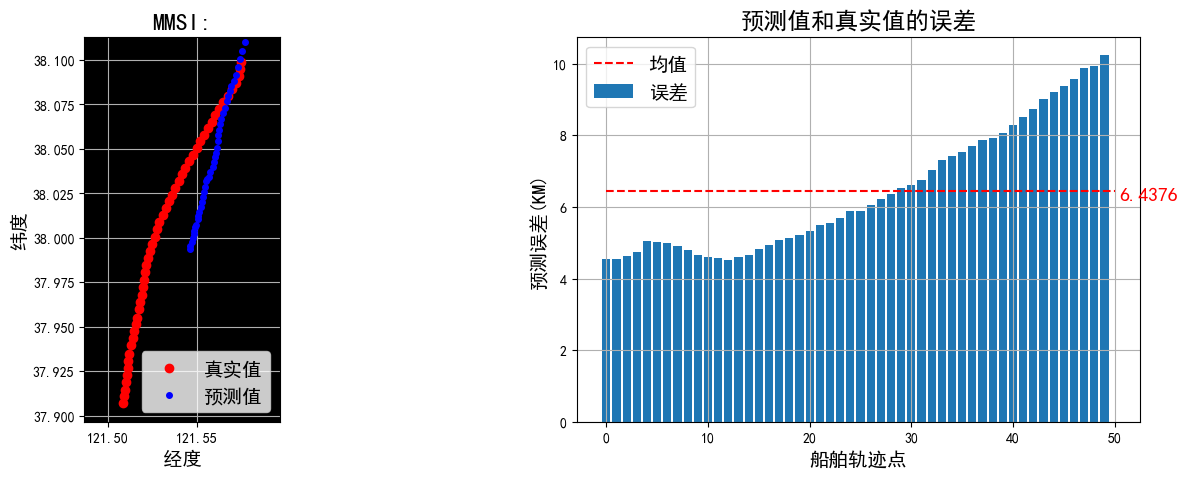

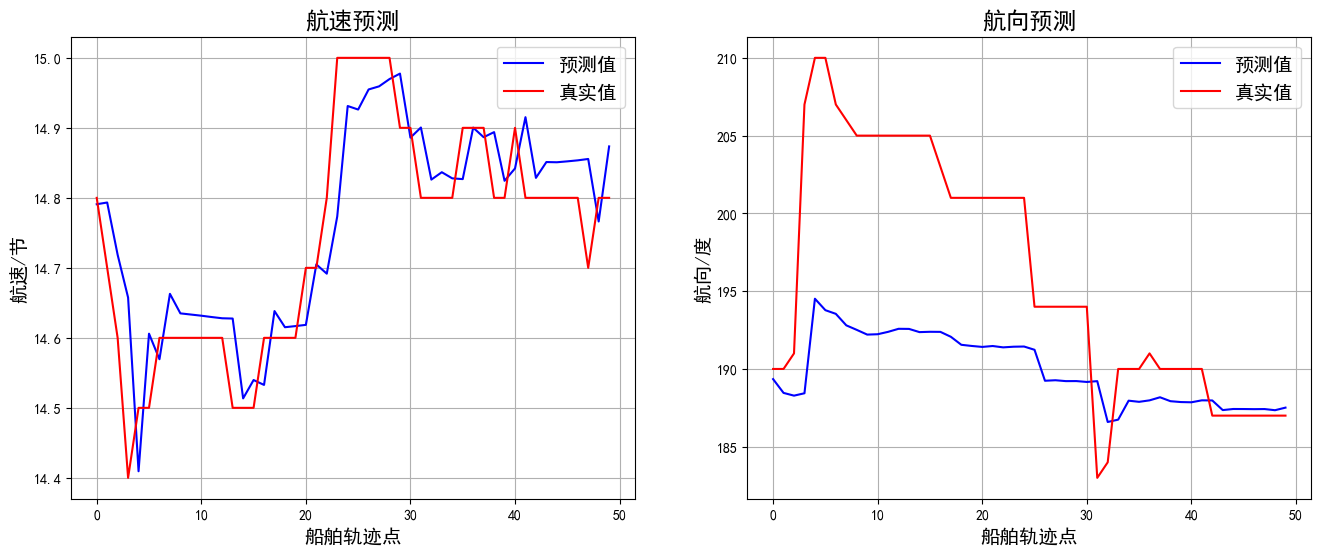

In [23]:
#单步预测
import transbigdata as tbd
test_points_ids = list(set(test['MMSI']))

for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test.MMSI == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 反归一化
    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
    bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
    tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()